# Model selection and parameter tuning

## Prepare notebook

Import libraries and functions

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sys
import os
sys.path.append('../src/features')
from build_features import get_dummies
sys.path.append('../src/models')
from predict_model import clint_scorer, trump_scorer, avg_scorer
#warnings.filterwarnings("ignore")

In [21]:
random.seed(10)

Load predictors and target variable

In [22]:
# with open('../data/processed/predictors.pickle', 'rb') as file:
#     X = pickle.load(file)
with open('../data/processed/target.pickle', 'rb') as file:
    y = pickle.load(file)

Load predictors without dummies 

In [23]:
with open('../data/processed/predictors_not_dummies.pickle', 'rb') as file:
     X_no = pickle.load(file)

## Split data into train and test sets

Split the 23 (no dummies) predictors into train and test set 

In [24]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_no, y)

## Define function to score model performance 

Create a metric to pass to cross_val_score when evaluating models

In [25]:
clinton_metric = make_scorer(clint_scorer)
trump_metric = make_scorer(trump_scorer)
comb_metric = make_scorer(avg_scorer)

## Define models 

Logistic regression

In [40]:
lr = LogisticRegression(
    C=2, penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000, random_state=3)

Random forest classifier

In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=3)

K-nearest neighbors

In [43]:
knn = KNeighborsClassifier()

Support vector machine

In [44]:
svm = SVC(kernel='linear', random_state=3)

##  Evaluate training performance

Create a list of model names and model variables 

In [45]:
name_list = ['Logistic regression', 'Random forest',
             'K-nearest neighbors', 'Support vector machine']
model_list = [lr, rf, knn, svm]

Cross validate all of the models and print scores and score mean for each for  Clinton 

In [46]:
for idx, model in enumerate(model_list):
    clint_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=clinton_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ":", clint_scores, round(clint_scores.mean(), 5))

Logistic regression : [90.4 91.5 89.3 90.8 89.8] 90.36
Random forest : [90.  89.7 88.1 88.9 90. ] 89.34
K-nearest neighbors : [86.5 88.5 86.1 84.9 87. ] 86.6
Support vector machine : [92.3 92.3 90.4 91.7 90.6] 91.46


Cross validate all of the models and print scores and score mean for each for Trump

In [47]:
for idx, model in enumerate(model_list):
    trump_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=trump_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ":", trump_scores, 'Mean:', round(trump_scores.mean(), 5))

Logistic regression : [85.9 85.7 87.5 90.  88. ] Mean: 87.42
Random forest : [86.7 88.8 90.  91.5 87.6] Mean: 88.92
K-nearest neighbors : [83.8 82.9 85.5 86.3 86.9] Mean: 85.08
Support vector machine : [85.7 85.  86.5 88.8 87.1] Mean: 86.62


Cross validate and evaluate using the combined Trump/Clinton metric on non-dummy predictors 

In [48]:
for idx, model in enumerate(model_list):
    comb_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=comb_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, comb_scores, comb_scores.mean())

Logistic regression [88.15 88.6  88.4  90.4  88.9 ] 88.88999999999999
Random forest [88.35 89.25 89.05 90.2  88.8 ] 89.13
K-nearest neighbors [85.15 85.7  85.8  85.6  86.95] 85.84
Support vector machine [89.   88.65 88.45 90.25 88.85] 89.04


Use recursive feature elimination on non-dummy variables on two top performing models (LR and RF)

In [51]:
selector_lr = RFECV(lr, step=1, min_features_to_select=1,
                    scoring=comb_metric, cv=5)
selector_lr.fit(X_train_rfe, y_train_rfe)

RFECV(cv=5,
      estimator=LogisticRegression(C=2, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=1000,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=3, solver='lbfgs',
                                   tol=0.0001, verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=make_scorer(avg_scorer),
      step=1, verbose=0)

In [54]:
selector_rf = RFECV(rf, step=1, min_features_to_select=1,  
                    scoring=comb_metric, cv=5)
selector_rf.fit(X_train_rfe, y_train_rfe)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=3,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=make_scorer(avg_scorer),
      step=1, verbose=0)

Print findings from RFE 

In [55]:
print('Optimal number of features: {}'.format(selector_lr.n_features_))
print('Optimal number of features: {}'.format(selector_rf.n_features_))

Optimal number of features: 9
Optimal number of features: 23


Print selected features from the RFE using logistic regression 

In [67]:
print(selector_lr.ranking_)
rank_list = selector_lr.ranking_
feature_ranks = []
no = []
yes = []
for idx, rank in enumerate(rank_list):
    feature_ranks.append([rank, X_train_rfe.columns[idx]])
for list in feature_ranks:
    if list[0] != 1:
        #print('no', list)
        no.append(list)
    if list[0] == 1:
        #print('yes', list)
        yes.append(list)
#print(no)
print(yes) # immigration, terrorism, climate change, the budget deficit, racial equality, 

[ 1 10  1  4  3  1  1 13  5 14 11  1 15  9  8  1  7  6  2 12  1  1  1]
[[1, 'imiss_a_2016'], [1, 'imiss_c_2016'], [1, 'imiss_f_2016'], [1, 'imiss_g_2016'], [1, 'imiss_l_2016'], [1, 'imiss_p_2016'], [1, 'imiss_u_2016'], [1, 'imiss_x_2016'], [1, 'imiss_y_2016']]


Selected feature count using non-dummies

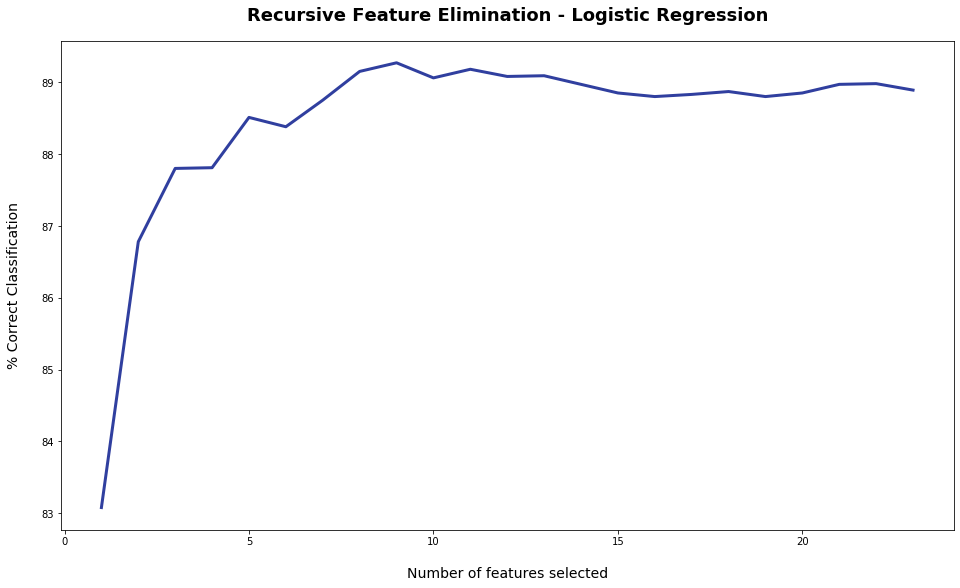

In [68]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination - Logistic Regression', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(selector_lr.grid_scores_) + 1), selector_lr.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

Drop unneeded attributes

In [69]:
print(np.where(selector_lr.support_ == False)[0])

X_dropped = X_no.drop(X_no.columns[np.where(selector_lr.support_ == False)[0]], axis=1)

[ 1  3  4  7  8  9 10 12 13 14 16 17 18 19]


In [98]:
print(len(X_dropped.columns))
X_dropped.head()


9


,imiss_a_2016,imiss_c_2016,imiss_f_2016,imiss_g_2016,imiss_l_2016,imiss_p_2016,imiss_u_2016,imiss_x_2016,imiss_y_2016
0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0
1,1.0,2.0,1.0,4.0,4.0,1.0,2.0,3.0,4.0
2,1.0,2.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0
3,1.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0
4,1.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0


Get dummies for X with fewer attributes

In [71]:
X = get_dummies(X_dropped)

Number of columns in new X 

In [72]:
len(X.columns)

36

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Show rfe feature importances

## Parameter tuning

Define parameter grid for random forest

In [74]:
param_grid = {'n_estimators': [100], 'max_depth': [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'oob_score': [True], 'max_features': [None, 'sqrt']}

Find the best parameters and then crossvalidate with five folds

In [77]:
grid = GridSearchCV(rf, param_grid, iid=True, cv=5, n_jobs=-1,
                    scoring=comb_metric, verbose=1, return_train_score=True)

Fit training data to grid

In [99]:
lr.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
lr.coef_

array([[ 0.07937392,  0.42934026,  0.66457478, -0.03698937,  0.44279562,
         0.59969262,  0.46952508,  0.11708019,  0.2012351 ,  0.10544338,
         0.05971256,  0.18226675, -0.2261798 , -0.46914026, -0.72040081,
        -0.50071449, -0.61178001, -1.47090024, -1.99900977, -0.50254861,
         0.43999515,  0.69979355,  0.4622185 ,  0.3814029 ,  0.50141263,
         1.06686984,  1.41569484,  0.39045779, -0.40887705, -0.80142715,
        -1.11604996, -0.2628891 , -0.44156308, -0.59803681, -0.51855404,
        -0.31376773],
       [-0.11059773, -0.32832178, -0.6045839 ,  0.29271035, -0.53020948,
        -0.90443869, -0.80519231, -0.48521051, -0.54938896, -1.0185643 ,
        -1.21791663, -0.33409511,  0.32351632,  0.52389987,  0.73002496,
         0.560831  ,  0.81402113,  1.43808939,  1.87853051,  0.80738217,
        -0.19977666, -0.56610027, -0.33948866, -0.34550492, -0.35411024,
        -0.97270185, -1.20701923, -0.56486645,  0.33912965,  0.75358392,
         0.85204291,  0.44919

In [116]:
lr.classes_

array([1., 2., 3.])

In [117]:
lr.intercept_

array([ 0.913321  , -0.46978294, -0.44353807])

In [106]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=3,
                                              verbose=0, warm_start=False),
             iid=True, n_jobs=-1,
             param_grid={'max_dept

Print best parameters and best score

In [79]:
print(grid.best_params_)
print(round(grid.best_score_, 3))

{'max_depth': 9, 'max_features': None, 'n_estimators': 100, 'oob_score': True}
88.7


In [111]:
lr.predict(X_train)
scores_train_lr = cross_validate(lr, X_train, y_train, scoring=comb_metric, cv=5)

In [115]:
scores_train_lr

{'fit_time': array([0.16303706, 0.14747977, 0.11915278, 0.11568308, 0.13249421]),
 'score_time': array([0.00851297, 0.00655532, 0.00729823, 0.0117979 , 0.0066607 ]),
 'test_score': array([89.45, 88.8 , 90.8 , 90.15, 89.75])}

## Evaluate test performance

In [112]:
scores_rf = cross_validate(grid, X_test, y_test, scoring=comb_metric, cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


In [113]:
scores_rf['test_score'].mean()

85.96

In [114]:
scores_lr = cross_validate(lr, X_test, y_test, scoring=comb_metric, cv=5)
scores_lr['test_score'].mean()

88.09